# Chest X-Ray Medical Diagnosis with Deep Learning
The chest x-ray images taken from the public [ChestX-ray8 dataset](https://arxiv.org/abs/1705.02315).

In [2]:
 # Import necessary packages
import keras
from keras import backend as K
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
import cv2
import sklearn
import shap
import os
import seaborn as sns
import time
import pickle
from PIL import Image
from sklearn.model_selection import train_test_split
sns.set()

# Sets a common size for all the figures we will draw.
plt.rcParams['figure.figsize'] = [10, 7]

/opt/homebrew/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Data Exploration

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# read csv
df1 = pd.read_csv(r"/Users/william/Desktop/LongTailCXR/nih-cxr-lt_single-label_train.csv")
df2 = pd.read_csv(r"/Users/william/Desktop/LongTailCXR/nih-cxr-lt_single-label_test.csv")
df = pd.concat([df1,df2])
df_unique = df.drop_duplicates(subset='subject_id')
df_unique

,id,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,...,Pleural_Thickening,Pneumonia,Pneumothorax,Pneumoperitoneum,Pneumomediastinum,Subcutaneous Emphysema,Tortuous Aorta,Calcification of the Aorta,No Finding,subject_id
0,00000001_000.png,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,00000002_000.png,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,2
2,00000005_000.png,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,5
9,00000006_000.png,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,6
10,00000007_000.png,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20274,00030777_000.png,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,30777
20275,00030782_000.png,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,30782
20276,00030789_000.png,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,30789
20277,00030797_000.png,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,30797


In [4]:
disease_columns = df_unique.columns[1:-2]

#transform dataset's format
df_unique['Diseases'] = df_unique[disease_columns].apply(lambda x: ', '.join(disease_columns[x == 1]), axis=1)
df_unique['Diseases'] = df_unique['Diseases'].replace('', 'No Finding')

/var/folders/b0/pcxb6s654pd13jyf_cx6mwp00000gn/T/ipykernel_41701/3046501596.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_unique['Diseases'] = df_unique[disease_columns].apply(lambda x: ', '.join(disease_columns[x == 1]), axis=1)
/var/folders/b0/pcxb6s654pd13jyf_cx6mwp00000gn/T/ipykernel_41701/3046501596.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_unique['Diseases'] = df_unique['Diseases'].replace('', 'No Finding')


Diseases
No Finding                    21513
Infiltration                   2656
Atelectasis                     927
Nodule                          915
Mass                            699
Effusion                        501
Cardiomegaly                    451
Pleural_Thickening              393
Fibrosis                        313
Tortuous Aorta                  213
Pneumothorax                    200
Emphysema                       161
Consolidation                   157
Calcification of the Aorta       94
Pneumonia                        63
Hernia                           42
Edema                            26
Pneumoperitoneum                 17
Subcutaneous Emphysema            4
Pneumomediastinum                 3
Name: count, dtype: int64


/var/folders/b0/pcxb6s654pd13jyf_cx6mwp00000gn/T/ipykernel_41701/3858441055.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=disease_counts.values, y=disease_counts.index, palette="viridis")


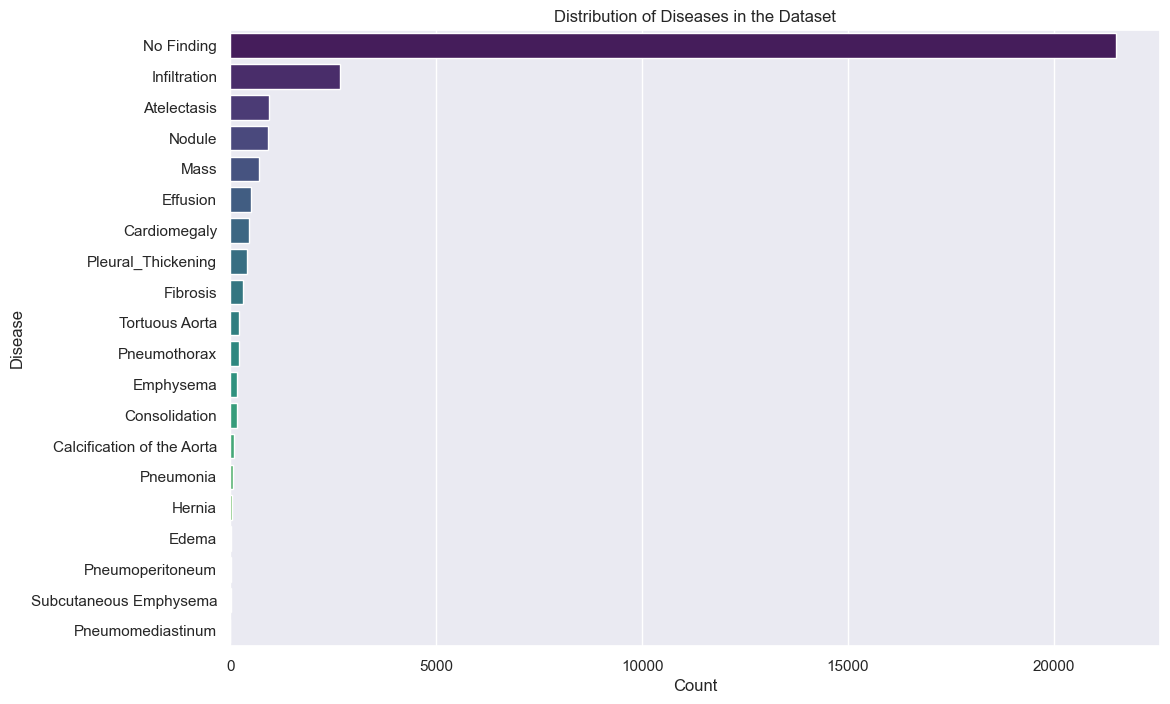

In [5]:
disease_counts = df_unique['Diseases'].value_counts()
print(disease_counts)
plt.figure(figsize=(12, 8))
sns.barplot(x=disease_counts.values, y=disease_counts.index, palette="viridis")
plt.title('Distribution of Diseases in the Dataset')
plt.xlabel('Count')
plt.ylabel('Disease')
plt.show()

In [6]:
# Try to balance-sample the data
n_samples_per_disease = 10000 // len(disease_columns)

sampled_df = pd.DataFrame()

for disease, group in df_unique.groupby('Diseases'):
    samples_to_add = min(len(group), n_samples_per_disease)
    sampled_df = pd.concat([sampled_df, group.sample(n=samples_to_add, random_state=42)], ignore_index=True)

if len(sampled_df) < 10000:
    additional_samples_needed = 10000 - len(sampled_df)
    additional_samples = df_unique.sample(n=additional_samples_needed, random_state=42)
    sampled_df = pd.concat([sampled_df, additional_samples]).drop_duplicates().reset_index(drop=True)

Diseases
No Finding                    3949
Infiltration                   825
Atelectasis                    605
Nodule                         589
Mass                           550
Effusion                       501
Cardiomegaly                   451
Pleural_Thickening             393
Fibrosis                       313
Tortuous Aorta                 213
Pneumothorax                   200
Emphysema                      161
Consolidation                  157
Calcification of the Aorta      94
Pneumonia                       63
Hernia                          42
Edema                           26
Pneumoperitoneum                17
Subcutaneous Emphysema           4
Pneumomediastinum                3
Name: count, dtype: int64


/var/folders/b0/pcxb6s654pd13jyf_cx6mwp00000gn/T/ipykernel_41701/2456190658.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=disease_counts.values, y=disease_counts.index, palette="viridis")


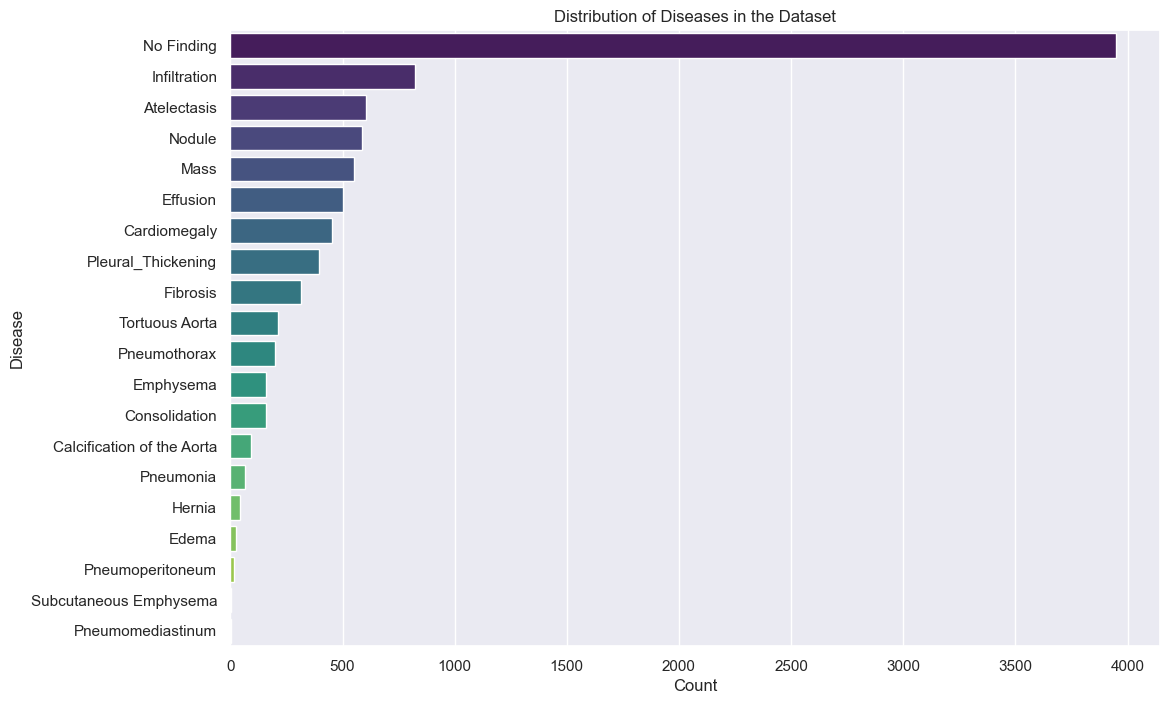

In [7]:
disease_counts = sampled_df['Diseases'].value_counts()
print(disease_counts)
plt.figure(figsize=(12, 8))
sns.barplot(x=disease_counts.values, y=disease_counts.index, palette="viridis")
plt.title('Distribution of Diseases in the Dataset')
plt.xlabel('Count')
plt.ylabel('Disease')
plt.show()

### Data Visualization

Display Random Images


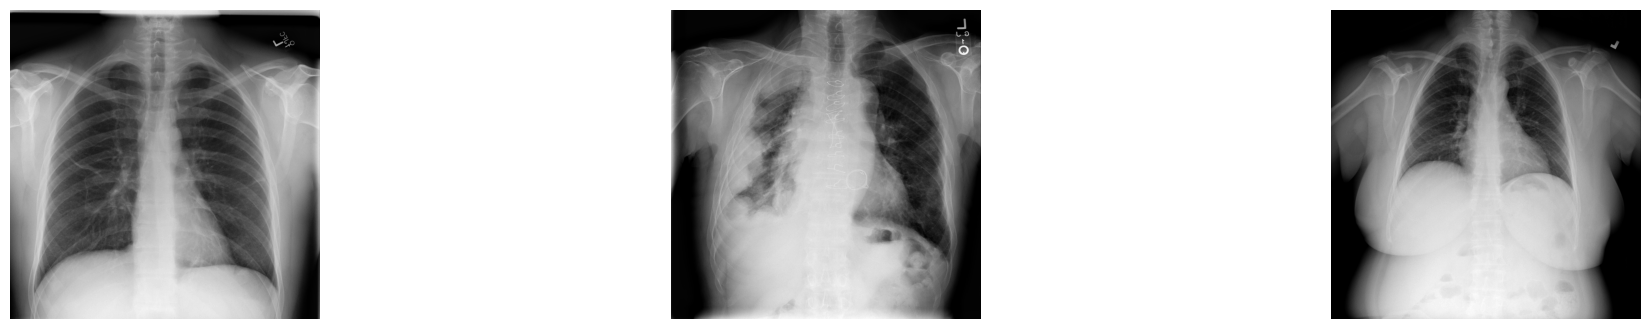

In [8]:
# Extract numpy values from Image column in data frame
images = sampled_df['id'].values

# Extract 4 random images from it
random_images = [np.random.choice(images) for i in range(3)]

# Location of the image dir
img_dir = "/Users/william/Desktop/images"

print('Display Random Images')

# Adjust the size of your images
plt.figure(figsize=(20,10))

# Iterate and plot random images
for i in range(3):
    plt.subplot(3, 3, i + 1)
    img = plt.imread(os.path.join(img_dir, random_images[i]))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    
# Adjust subplot parameters to give specified padding
plt.tight_layout()    

### Investigate a single image

The dimensions of the image are 1024 pixels width and 1024 pixels height, one single color channel
The maximum pixel value is 0.8941 and the minimum is 0.0039
The mean value of the pixels is 0.5941 and the standard deviation is 0.1700


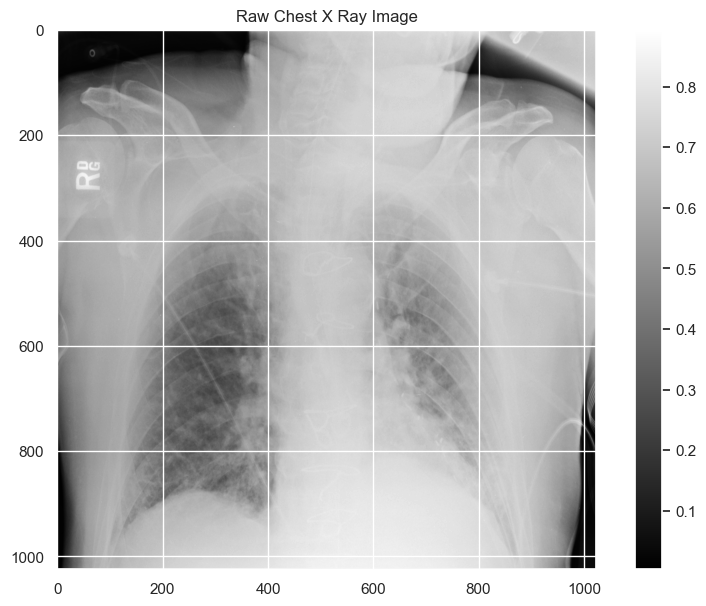

In [9]:
# Get the first image that was listed in the train_df dataframe
sample_img = sampled_df.iloc[0]['id']
raw_image = plt.imread(os.path.join(img_dir, sample_img))
plt.imshow(raw_image, cmap='gray')
plt.grid(color='w', linestyle='-', linewidth=1)
plt.colorbar()
plt.title('Raw Chest X Ray Image')
print(f"The dimensions of the image are {raw_image.shape[0]} pixels width and {raw_image.shape[1]} pixels height, one single color channel")
print(f"The maximum pixel value is {raw_image.max():.4f} and the minimum is {raw_image.min():.4f}")
print(f"The mean value of the pixels is {raw_image.mean():.4f} and the standard deviation is {raw_image.std():.4f}")

### Addressing Class Imbalance - Weighted Loss

Diseases
No Finding                    3949
Infiltration                   825
Atelectasis                    605
Nodule                         589
Mass                           550
Effusion                       501
Cardiomegaly                   451
Pleural_Thickening             393
Fibrosis                       313
Tortuous Aorta                 213
Pneumothorax                   200
Emphysema                      161
Consolidation                  157
Calcification of the Aorta      94
Pneumonia                       63
Hernia                          42
Edema                           26
Pneumoperitoneum                17
Subcutaneous Emphysema           4
Pneumomediastinum                3
Name: count, dtype: int64


/var/folders/b0/pcxb6s654pd13jyf_cx6mwp00000gn/T/ipykernel_41701/1407340540.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=disease_counts.values, y=disease_counts.index, palette="viridis")


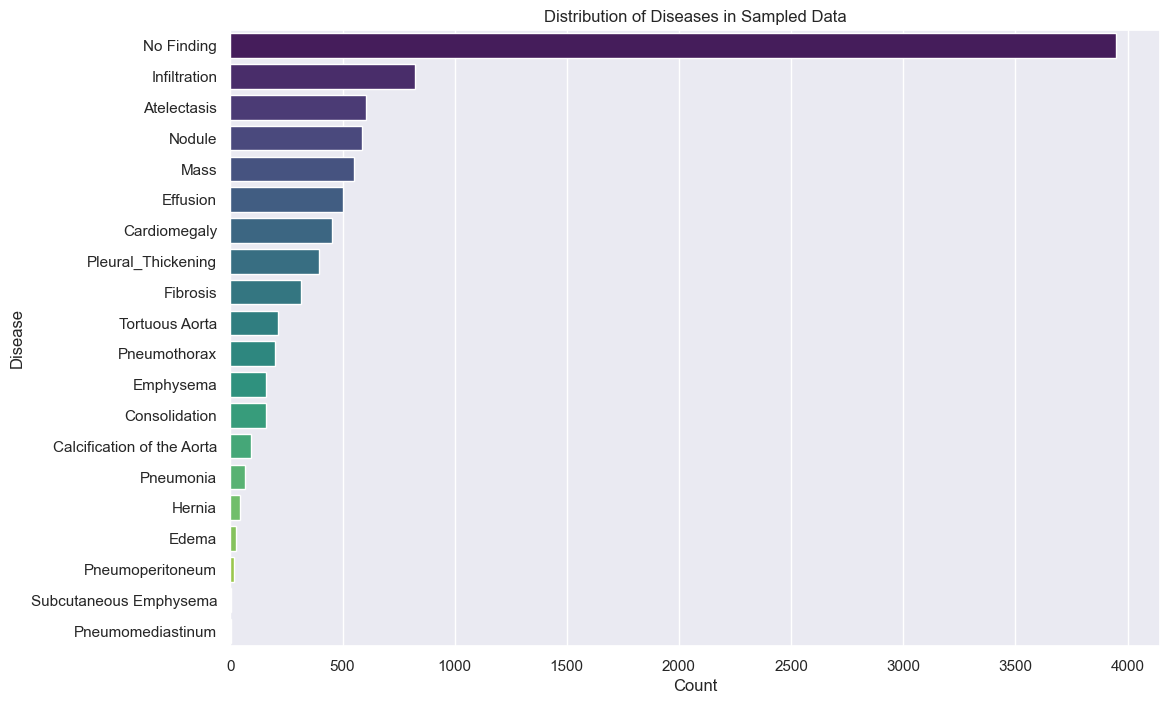

In [10]:
#plot the distribution of disease type
disease_counts = sampled_df['Diseases'].value_counts()
print(disease_counts)

plt.figure(figsize=(12, 8))
sns.barplot(x=disease_counts.values, y=disease_counts.index, palette="viridis")
plt.title('Distribution of Diseases in Sampled Data')
plt.xlabel('Count')
plt.ylabel('Disease')
plt.show()

We can see from this plot that the prevalance of positive cases varies significantly across the different pathologies. (These trends mirror the ones in the full dataset as well.) 
* The `No Finding` pathology has the greatest imbalance

Ideally, we would train our model using an evenly balanced dataset so that the positive and negative training cases would contribute equally to the loss. 

Diseases
No Finding                    500
Infiltration                  500
Subcutaneous Emphysema        500
Pneumoperitoneum              500
Edema                         500
Hernia                        500
Pneumonia                     500
Calcification of the Aorta    500
Consolidation                 500
Emphysema                     500
Pneumothorax                  500
Tortuous Aorta                500
Fibrosis                      500
Pleural_Thickening            500
Cardiomegaly                  500
Effusion                      500
Mass                          500
Nodule                        500
Atelectasis                   500
Pneumomediastinum             500
Name: count, dtype: int64


/var/folders/b0/pcxb6s654pd13jyf_cx6mwp00000gn/T/ipykernel_41701/499843746.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=balanced_disease_count.values, y=balanced_disease_count.index, palette="viridis")


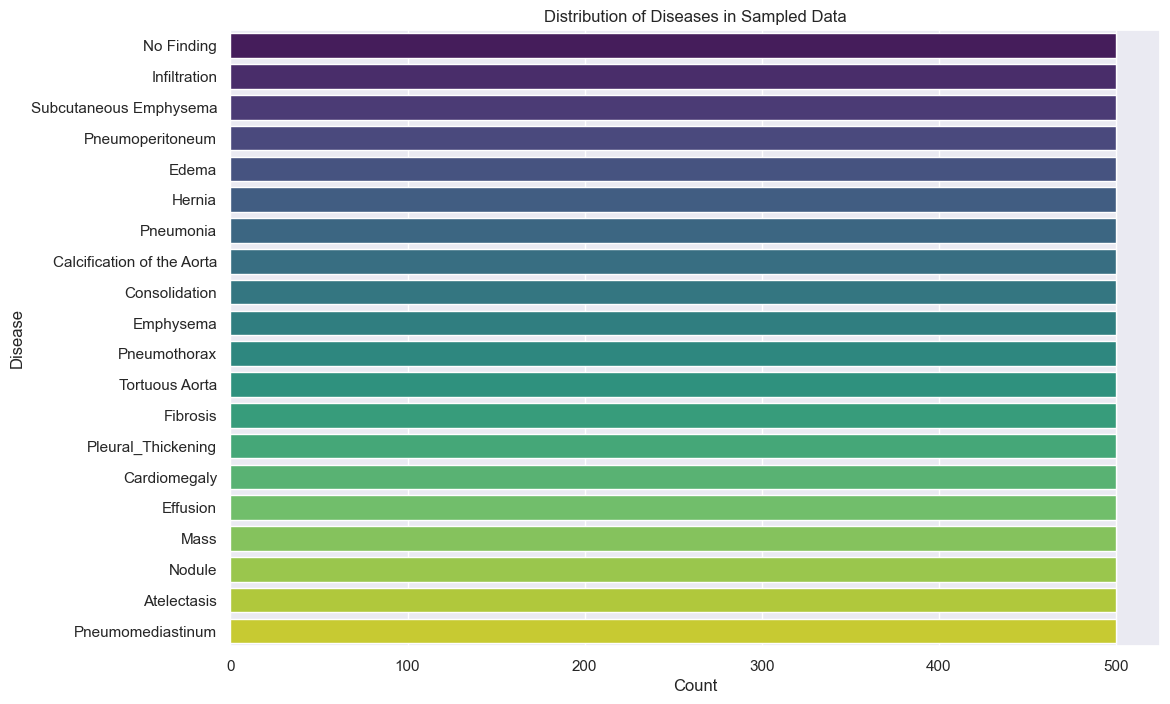

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

def balance_dataset(df, target_count):
    class_counts = df['Diseases'].value_counts()
    balanced_df = pd.DataFrame(columns=df.columns)
    for class_label, count in class_counts.items():
        if count < target_count:
            class_samples = df[df['Diseases'] == class_label].sample(n=target_count, replace=True, random_state=42)
        else:
            class_samples = df[df['Diseases'] == class_label].sample(n=target_count, random_state=42)
        balanced_df = pd.concat([balanced_df, class_samples], ignore_index=True)
    return balanced_df

# Assuming df_unique is your original dataframe with unique records
balanced_df = balance_dataset(df_unique, 500)
balanced_disease_count = balanced_df['Diseases'].value_counts()
print(balanced_disease_count)

plt.figure(figsize=(12, 8))
sns.barplot(x=balanced_disease_count.values, y=balanced_disease_count.index, palette="viridis")
plt.title('Distribution of Diseases in Sampled Data')
plt.xlabel('Count')
plt.ylabel('Disease')
plt.show()


### Split the balanced data into train, test, and validation

In [12]:
train_val_data, test_df = train_test_split(balanced_df, test_size=0.2, random_state=42)
train_df, valid_df = train_test_split(train_val_data, test_size=0.25, random_state=42)

print(f'There are {train_df.shape[0]} rows and {train_df.shape[1]} columns in the train data frame')
print(f'There are {valid_df.shape[0]} rows and {train_df.shape[1]} columns in the train data frame')
print(f'There are {test_df.shape[0]} rows and {train_df.shape[1]} columns in the train data frame')

There are 6000 rows and 23 columns in the train data frame
There are 2000 rows and 23 columns in the train data frame
There are 2000 rows and 23 columns in the train data frame


In [13]:
column_list = list(train_df.columns)
print(column_list)

['id', 'Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax', 'Pneumoperitoneum', 'Pneumomediastinum', 'Subcutaneous Emphysema', 'Tortuous Aorta', 'Calcification of the Aorta', 'No Finding', 'subject_id', 'Diseases']


### Investigate pixel value distribution

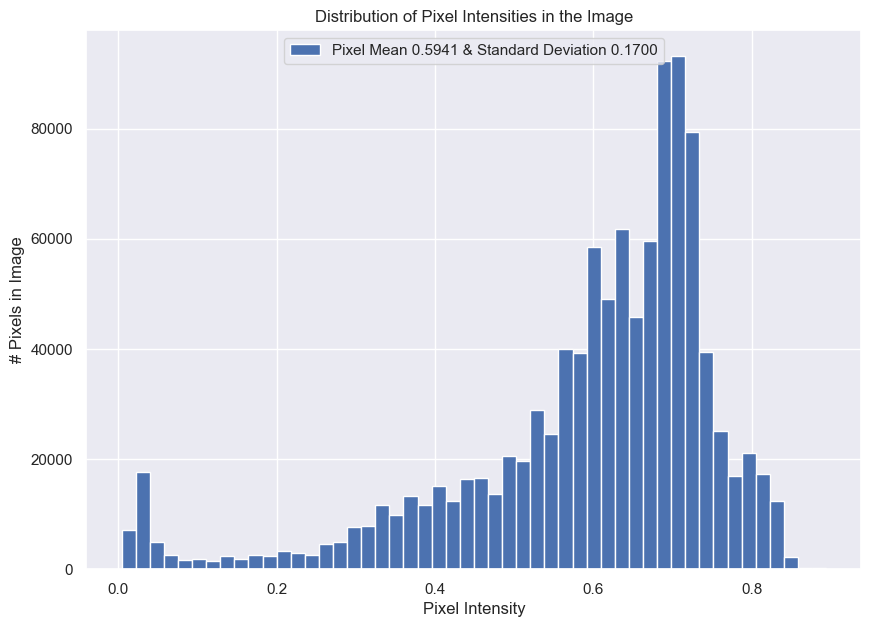

In [14]:
pixels = np.reshape(raw_image,raw_image.shape[0]*raw_image.shape[1])
plt.hist(pixels, bins=50, label=f'Pixel Mean {np.mean(raw_image):.4f} & Standard Deviation {np.std(raw_image):.4f}')
plt.legend(loc='upper center')
plt.title('Distribution of Pixel Intensities in the Image')
plt.xlabel('Pixel Intensity')
plt.ylabel('# Pixels in Image')
plt.show()

### Standardization

Normalizing images is better suited for training a convolutional neural network. For this task we use the Keras [ImageDataGenerator](https://keras.io/preprocessing/image/) function to perform data preprocessing and data augmentation.
The `image_generator` will adjust the image data such that the new mean of the data will be zero, and the standard deviation of the data will be 1.  

In other words, the generator will replace each pixel value in the image with a new value calculated by subtracting the mean and dividing by the standard deviation.

$$\frac{x_i - \mu}{\sigma}$$

Create an image generator for preprocessing. Pre-process the data using the `image_generator`as well as reduce the image size down to 320x320 pixels.

In [15]:
# Import data generator from keras https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import resample

making both target_w and target_h to 320: A size of 320x320 strikes a balance between retaining enough detail for the model to learn relevant features from the images and not being so large as to excessively increase computational complexity.

### Get_train_generator

In [16]:
def get_train_generator(df, image_dir, x_col, y_col, shuffle=True, batch_size=8, seed=1, target_w=320, target_h=320):
    image_generator = ImageDataGenerator(
        samplewise_center=True,              
        samplewise_std_normalization=True)
    
    generator = image_generator.flow_from_dataframe(
        dataframe=df,
        directory=image_dir,
        x_col=x_col,
        y_col=y_col,
        class_mode="raw",
        batch_size=batch_size,
        shuffle=shuffle,
        seed=seed,
        target_size=(target_w, target_h))
    
    return generator


In [17]:
labels = 'Diseases'
IMAGE_DIR = "/Users/william/Desktop/images"
train_generator = get_train_generator(train_df, IMAGE_DIR, "id", labels, batch_size=8)

Found 6000 validated image filenames.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The dimensions of the image are 320 pixels width and 320 pixels height
The maximum pixel value is 2.5891 and the minimum is -3.8864
The mean value of the pixels is 0.0000 and the standard deviation is 1.0000


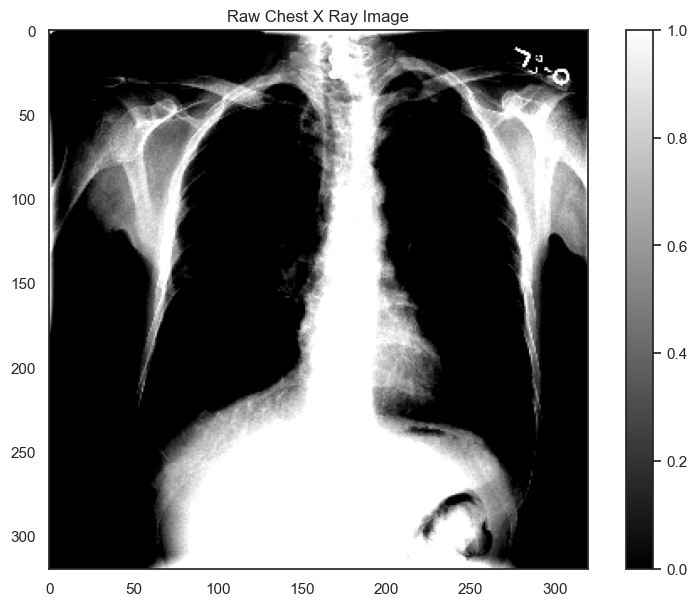

In [18]:
# Plot a processed image
sns.set_style("white")
generated_image, label = train_generator.__getitem__(0)
plt.imshow(generated_image[0], cmap='gray')
plt.colorbar()
plt.title('Raw Chest X Ray Image')
print(f"The dimensions of the image are {generated_image.shape[1]} pixels width and {generated_image.shape[2]} pixels height")
print(f"The maximum pixel value is {generated_image.max():.4f} and the minimum is {generated_image.min():.4f}")
print(f"The mean value of the pixels is {generated_image.mean():.4f} and the standard deviation is {generated_image.std():.4f}")

In [19]:
# What the first 8 x variables from generator look like
generated_image

array([[[[ 1.754088  ,  1.754088  ,  1.754088  ],
         [ 1.6063173 ,  1.6063173 ,  1.6063173 ],
         [ 0.86746347,  0.86746347,  0.86746347],
         ...,
         [-0.6397983 , -0.6397983 , -0.6397983 ],
         [-0.49202752, -0.49202752, -0.49202752],
         [-0.21126308, -0.21126308, -0.21126308]],

        [[ 1.4142153 ,  1.4142153 ,  1.4142153 ],
         [ 0.86746347,  0.86746347,  0.86746347],
         [ 0.05472429,  0.05472429,  0.05472429],
         ...,
         [-1.1422188 , -1.1422188 , -1.1422188 ],
         [-1.0683335 , -1.0683335 , -1.0683335 ],
         [-0.9353398 , -0.9353398 , -0.9353398 ]],

        [[ 0.21727213,  0.21727213,  0.21727213],
         [-0.3294797 , -0.3294797 , -0.3294797 ],
         [-0.8614544 , -0.8614544 , -0.8614544 ],
         ...,
         [-1.349098  , -1.349098  , -1.349098  ],
         [-1.3195438 , -1.3195438 , -1.3195438 ],
         [-1.3343209 , -1.3343209 , -1.3343209 ]],

        ...,

        [[-1.0831106 , -1.0831106 , -1

In [20]:
# The shape of the of the 8  x variables we got
print(generated_image.shape, generated_image[0].shape)
print(raw_image.shape)

(8, 320, 320, 3) (320, 320, 3)
(1024, 1024)


In [21]:
# What are the labels of the 8 x variables we got
label

array(['Emphysema', 'Pneumothorax', 'Hernia', 'Edema', 'Effusion',
       'Calcification of the Aorta', 'Hernia', 'Pleural_Thickening'],
      dtype=object)

### Get the associated images for training, testing, and validation data

In [22]:
train_df.columns

Index(['id', 'Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema',
       'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass',
       'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax',
       'Pneumoperitoneum', 'Pneumomediastinum', 'Subcutaneous Emphysema',
       'Tortuous Aorta', 'Calcification of the Aorta', 'No Finding',
       'subject_id', 'Diseases'],
      dtype='object')

In [23]:
labels = train_df.columns[1:-2]

IMAGE_DIR = "/Users/william/Desktop/images"
train_generator = get_train_generator(train_df, IMAGE_DIR, "id", labels, batch_size=6000)
test_generator = get_train_generator(test_df, IMAGE_DIR, "id", labels, batch_size=2000)
valid_generator = get_train_generator(valid_df, IMAGE_DIR, "id", labels, batch_size=2000)

x_train, y_train = train_generator.__getitem__(0)
x_valid, y_valid = valid_generator.__getitem__(0)
x_test, y_test = test_generator.__getitem__(0)

Found 6000 validated image filenames.
Found 2000 validated image filenames.
Found 2000 validated image filenames.


### Data Preprocess for fitting the models

In [24]:
# flat image to fit the models

def flatten_images(x):
    x_flattened = x.reshape(x.shape[0], -1)

    all_images = np.vstack(x_flattened)
    
    return all_images

x_train_flat = flatten_images(x_train)
x_test_flat = flatten_images(x_test)
x_valid_flat = flatten_images(x_valid)

print(f'x_train_flat shape: {x_train_flat.shape}') 
print(f'x_test_flat shape: {x_test_flat.shape}') 
print(f'x_valid_flat shape: {x_valid_flat.shape}')

x_train_flat shape: (6000, 307200)
x_test_flat shape: (2000, 307200)
x_valid_flat shape: (2000, 307200)


In [25]:
print(f'x_train shape: {x_train.shape}') 
print(f'x_test shape: {x_test.shape}') 
print(f'x_val shape: {x_valid.shape}')

x_train shape: (6000, 320, 320, 3)
x_test shape: (2000, 320, 320, 3)
x_val shape: (2000, 320, 320, 3)


In [26]:
print(f'y_train shape: {y_train.shape}') 
print(f'y_test shape: {y_test.shape}') 
print(f'y_val shape: {y_valid.shape}')

y_train shape: (6000, 20)
y_test shape: (2000, 20)
y_val shape: (2000, 20)


In [27]:
y_combined = np.concatenate((y_train, y_test, y_valid), axis=0)

In [28]:
x_train = x_train.astype('float32')
y_train = y_train.astype('float32')
x_valid = x_valid.astype('float32')
y_valid = y_valid.astype('float32')
x_test = x_test.astype('float32')
y_test = y_test.astype('float32')

Atelectasis: 500 cases
Cardiomegaly: 500 cases
Consolidation: 500 cases
Edema: 500 cases
Effusion: 500 cases
Emphysema: 500 cases
Fibrosis: 500 cases
Hernia: 500 cases
Infiltration: 500 cases
Mass: 500 cases
Nodule: 500 cases
Pleural_Thickening: 500 cases
Pneumonia: 500 cases
Pneumothorax: 500 cases
Pneumoperitoneum: 500 cases
Pneumomediastinum: 500 cases
Subcutaneous Emphysema: 500 cases
Tortuous Aorta: 500 cases
Calcification of the Aorta: 500 cases
No Finding: 500 cases


/var/folders/b0/pcxb6s654pd13jyf_cx6mwp00000gn/T/ipykernel_41701/3938840711.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=each_disease, y=labels, palette="viridis")


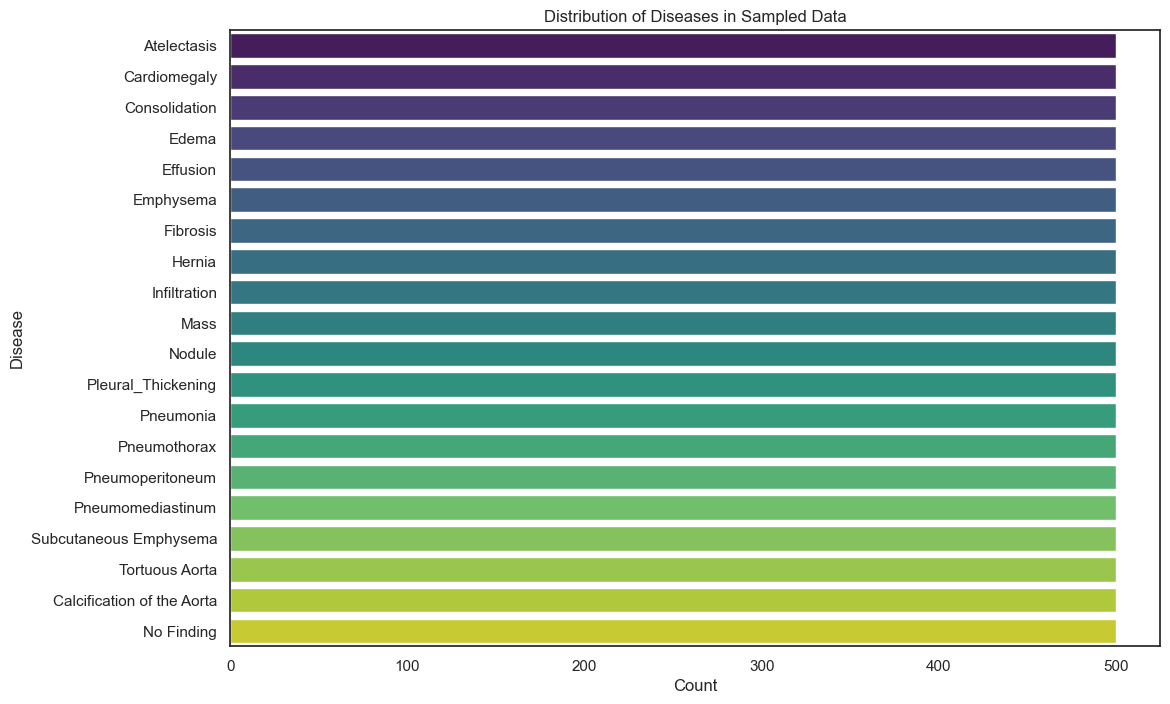

In [29]:
each_disease = []
for i in range(20):
    sum = y_combined[:,i].sum()
    each_disease.append(sum)

for i in range(20):
    print(f'{labels[i]}: {each_disease[i]} cases')

plt.figure(figsize=(12, 8))
sns.barplot(x=each_disease, y=labels, palette="viridis")
plt.title('Distribution of Diseases in Sampled Data')
plt.xlabel('Count')
plt.ylabel('Disease')
plt.show()

Atelectasis: 300.0 cases
Cardiomegaly: 287.0 cases
Consolidation: 291.0 cases
Edema: 310.0 cases
Effusion: 305.0 cases
Emphysema: 301.0 cases
Fibrosis: 301.0 cases
Hernia: 280.0 cases
Infiltration: 302.0 cases
Mass: 283.0 cases
Nodule: 303.0 cases
Pleural_Thickening: 300.0 cases
Pneumonia: 307.0 cases
Pneumothorax: 324.0 cases
Pneumoperitoneum: 293.0 cases
Pneumomediastinum: 295.0 cases
Subcutaneous Emphysema: 312.0 cases
Tortuous Aorta: 303.0 cases
Calcification of the Aorta: 300.0 cases
No Finding: 303.0 cases


/var/folders/b0/pcxb6s654pd13jyf_cx6mwp00000gn/T/ipykernel_41701/2046819837.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=each_disease, y=labels, palette="viridis")


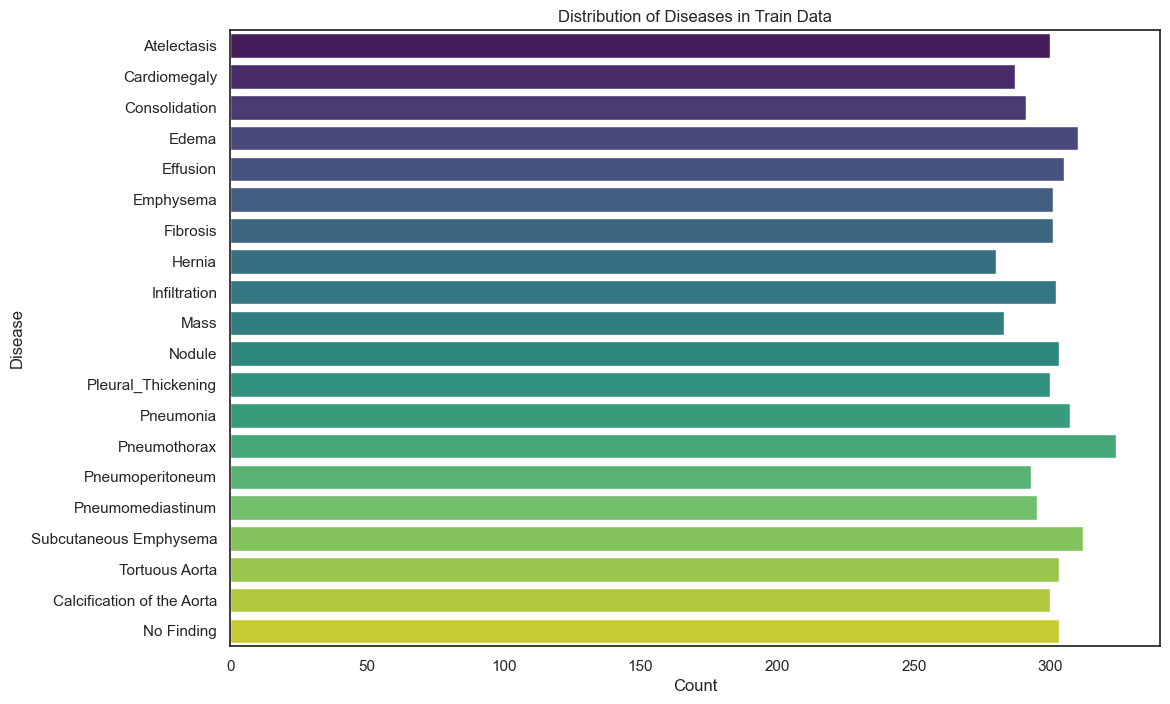

In [30]:
each_disease = []
for i in range(20):
    sum = y_train[:,i].sum()
    each_disease.append(sum)

for i in range(20):
    print(f'{labels[i]}: {each_disease[i]} cases')

plt.figure(figsize=(12, 8))
sns.barplot(x=each_disease, y=labels, palette="viridis")
plt.title('Distribution of Diseases in Train Data')
plt.xlabel('Count')
plt.ylabel('Disease')
plt.show()

## Fully connected neural network (FCN) model for multi-class classification.

1. **Model Type**: Fully connected (Dense) neural network model.

2. **Model Architecture**:
   - Input Layer: 256 neurons
   - Hidden Layers: 128 neurons, 64 neurons, 32 neurons, 16 neurons, all using Leaky ReLU activation functions
   - Output Layer: Using sigmoid activation function for multi-label classification

3. **Image Processing**: The model uses flattened images as input.

4. **Optimization Methods**:
   - Optimizer: Adam with a learning rate of 0.001
   - Loss Function: binary_crossentropy
   - Evaluation Metric: accuracy
   - Callback Function: LossHistory, used to record losses and accuracies during training

The code also includes AUC evaluation, calculating and visualizing AUC scores for each class.


Epoch 1/60
600/600 ━━━━━━━━━━━━━━━━━━━━ 143s 237ms/step - accuracy: 0.0868 - loss: 2.7804 - val_accuracy: 0.1815 - val_loss: 0.3113
Epoch 2/60
600/600 ━━━━━━━━━━━━━━━━━━━━ 131s 218ms/step - accuracy: 0.1957 - loss: 0.2928 - val_accuracy: 0.2410 - val_loss: 0.2446
Epoch 3/60
600/600 ━━━━━━━━━━━━━━━━━━━━ 134s 222ms/step - accuracy: 0.2834 - loss: 0.1873 - val_accuracy: 0.2500 - val_loss: 0.2107
Epoch 4/60
600/600 ━━━━━━━━━━━━━━━━━━━━ 132s 220ms/step - accuracy: 0.3126 - loss: 0.1752 - val_accuracy: 0.2735 - val_loss: 0.1946
Epoch 5/60
600/600 ━━━━━━━━━━━━━━━━━━━━ 136s 227ms/step - accuracy: 0.3430 - loss: 0.1650 - val_accuracy: 0.3480 - val_loss: 0.1704
Epoch 6/60
600/600 ━━━━━━━━━━━━━━━━━━━━ 135s 225ms/step - accuracy: 0.3394 - loss: 0.1775 - val_accuracy: 0.3175 - val_loss: 0.1994
Epoch 7/60
600/600 ━━━━━━━━━━━━━━━━━━━━ 139s 231ms/step - accuracy: 0.3232 - loss: 0.1761 - val_accuracy: 0.3305 - val_loss: 0.2269
Epoch 8/60
600/600 ━━━━━━━━━━━━━━━━━━━━ 139s 230ms/step - accuracy: 0.3391 -

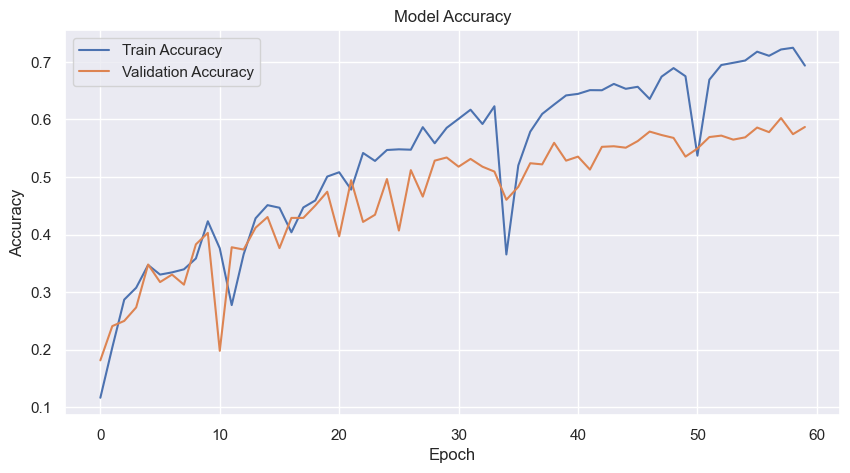

63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step
Class 0 AUC: 0.7729523221294654
Class 1 AUC: 0.915642730496454
Class 2 AUC: 0.969539762409201
Class 3 AUC: 0.9877525559883155
Class 4 AUC: 0.8162361838278068
Class 5 AUC: 0.968464988519067
Class 6 AUC: 0.8624700450055527
Class 7 AUC: 1.0
Class 8 AUC: 0.8165575691817945
Class 9 AUC: 0.7758863819500403
Class 10 AUC: 0.7693342962184874
Class 11 AUC: 0.8824683637954438
Class 12 AUC: 0.9999613206243956
Class 13 AUC: 0.930451217192849
Class 14 AUC: 1.0
Class 15 AUC: 1.0
Class 16 AUC: 1.0
Class 17 AUC: 0.9336123136123136
Class 18 AUC: 0.969952018873639
Class 19 AUC: 0.7576630229928383


/var/folders/b0/pcxb6s654pd13jyf_cx6mwp00000gn/T/ipykernel_21539/3034962032.py:79: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(x='Class', y='AUC Score', data=auc_df, palette='viridis')


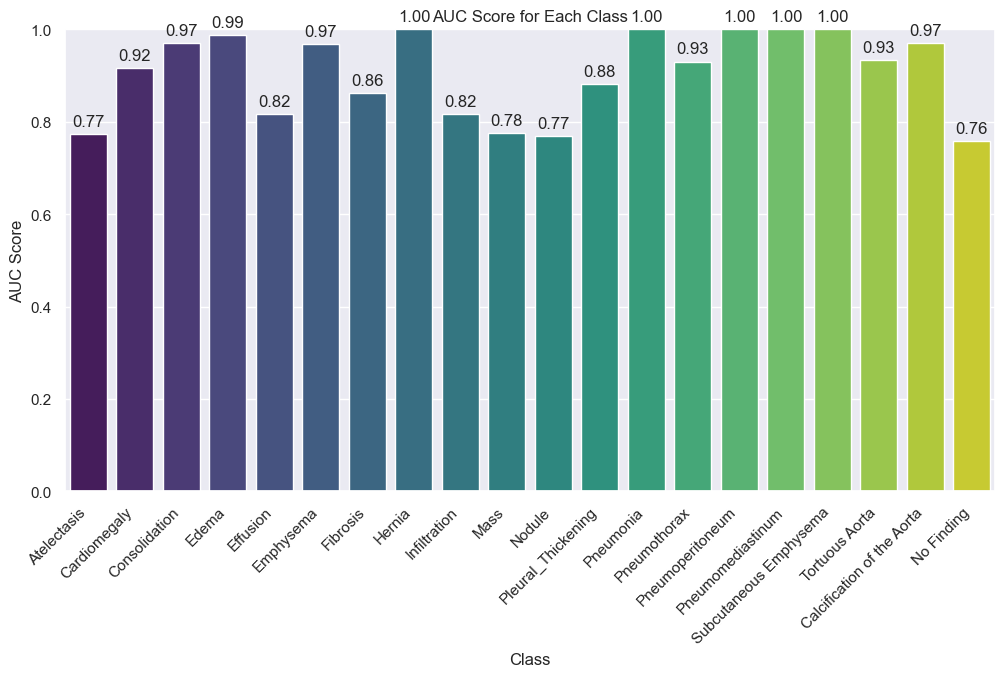

In [52]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LeakyReLU
from tensorflow.keras.callbacks import Callback
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import roc_auc_score
import numpy as np

class LossHistory(Callback):
    def on_train_begin(self, logs=None):
        self.total_batches = 0 
        self.losses = []
        self.val_losses = []
        self.iterations = []
        self.accuracy = []
        self.val_accuracy = []

    def on_batch_end(self, batch, logs=None):
        self.total_batches += 1 
        if self.total_batches % 100 == 0:
            self.losses.append(logs.get('loss'))
            self.iterations.append(self.total_batches)
            
    def on_epoch_end(self, epoch, logs=None):
        self.val_losses.append(logs.get('val_loss'))
        self.accuracy.append(logs.get('accuracy'))
        self.val_accuracy.append(logs.get('val_accuracy'))

history = LossHistory()

model = Sequential([
    Dense(256, input_dim=x_train_flat.shape[1]),
    LeakyReLU(),
    Dense(128),
    LeakyReLU(),
    Dense(64),
    LeakyReLU(),
    Dense(32),
    LeakyReLU(),
    Dense(16),
    LeakyReLU(),
    Dense(y_train.shape[1], activation='sigmoid')
])

learning_rate = 0.001
model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])

model.fit(x_train_flat, y_train, validation_data=(x_valid_flat, y_valid),
          epochs=60, batch_size=10, callbacks=[history])  


# Accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.accuracy, label='Train Accuracy')
plt.plot(history.val_accuracy, label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


# AUC
y_pred = model.predict(x_test_flat)

auc_scores = []
for i in range(y_test.shape[1]):
    auc = roc_auc_score(y_test[:, i], y_pred[:, i])
    auc_scores.append(auc)
    print(f"Class {i} AUC: {auc}")

import pandas as pd
auc_df = pd.DataFrame({
    'Class': labels,
    'AUC Score': auc_scores
})

plt.figure(figsize=(12, 6))
bar_plot = sns.barplot(x='Class', y='AUC Score', data=auc_df, palette='viridis')

for p in bar_plot.patches:
    bar_plot.annotate(format(p.get_height(), '.2f'),
                      (p.get_x() + p.get_width() / 2., p.get_height()),
                      ha='center', va='center',
                      xytext=(0, 9),
                      textcoords='offset points')

plt.title('AUC Score for Each Class')
plt.xlabel('Class')
plt.ylabel('AUC Score')
plt.ylim(0, 1)
plt.xticks(rotation=45, ha='right')
plt.show()


The following code implements a convolutional neural network (CNN) for multi-class classification. While it is inspired by the YOLO (You Only Look Once) architecture in terms of using multiple convolutional layers, it is not a full YOLO implementation, which is typically used for object detection. The key differences compared to the previous model are as follows:

1. **Model Type**: This model is a convolutional neural network (CNN) designed for image classification.

2. **Model Architecture**:
   - **Convolutional Layers**: The model includes multiple Conv2D layers with Leaky ReLU activations and MaxPooling2D layers to progressively downsample the input image.
   - **Dense Layers**: After flattening the output of the convolutional layers, the model includes a dense layer with 1024 neurons and Leaky ReLU activation before the final output layer.
   - **Input Shape**: The model takes images of shape (320, 320, 3) as input, unlike the previous model that used flattened images.
   - **Output Layer**: The final layer uses a sigmoid activation function for multi-label classification, similar to the previous model.

3. **Optimization Methods**:
   - The optimizer, loss function, and evaluation metric remain the same as in the previous model (Adam with a learning rate of 0.001, binary_crossentropy, and accuracy, respectively).
   - **Early Stopping**: This model uses an EarlyStopping callback to prevent overfitting by monitoring the validation loss and stopping training if there is no improvement for 5 epochs.

4. **Image Processing**: Unlike the previous model, which used flattened images, this model uses images with spatial dimensions, leveraging convolutional layers to extract spatial features.

The code also includes AUC evaluation, calculating and visualizing AUC scores for each class, similar to the previous model.


/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 433s 1s/step - accuracy: 0.1410 - loss: 0.2288 - val_accuracy: 0.3230 - val_loss: 0.1560
Epoch 2/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 424s 1s/step - accuracy: 0.3771 - loss: 0.1419 - val_accuracy: 0.4560 - val_loss: 0.1284
Epoch 3/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 414s 1s/step - accuracy: 0.5877 - loss: 0.1014 - val_accuracy: 0.5770 - val_loss: 0.1055
Epoch 4/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 430s 1s/step - accuracy: 0.7478 - loss: 0.0661 - val_accuracy: 0.6430 - val_loss: 0.1012
Epoch 5/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 412s 1s/step - accuracy: 0.8822 - loss: 0.0366 - val_accuracy: 0.6605 - val_loss: 0.1171
Epoch 6/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 430s 1s/step - accuracy: 0.9530 - loss: 0.0212 - val_accuracy: 0.6490 - val_loss: 0.1610
Epoch 7/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 433s 1s/step - accuracy: 0.9764 - loss: 0.0127 - val_accuracy: 0.6440 - val_loss: 0.2143
Epoch 8/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 381s 1s/step - accuracy: 0.9818 - loss: 0.0134 - val_accu

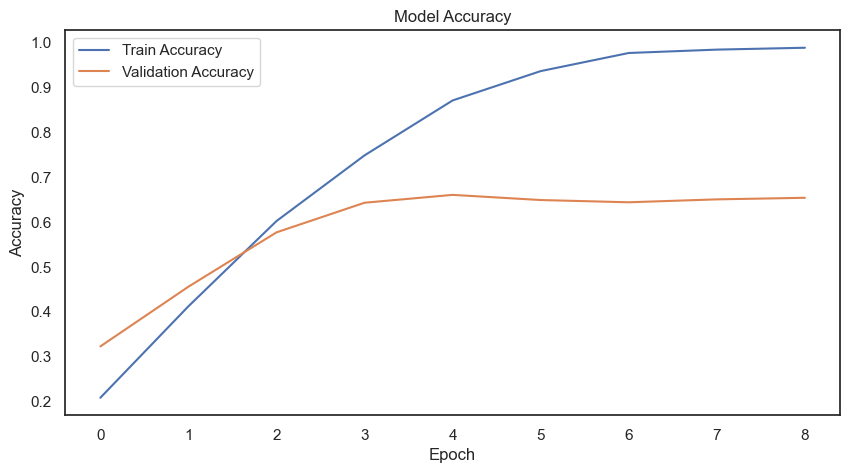

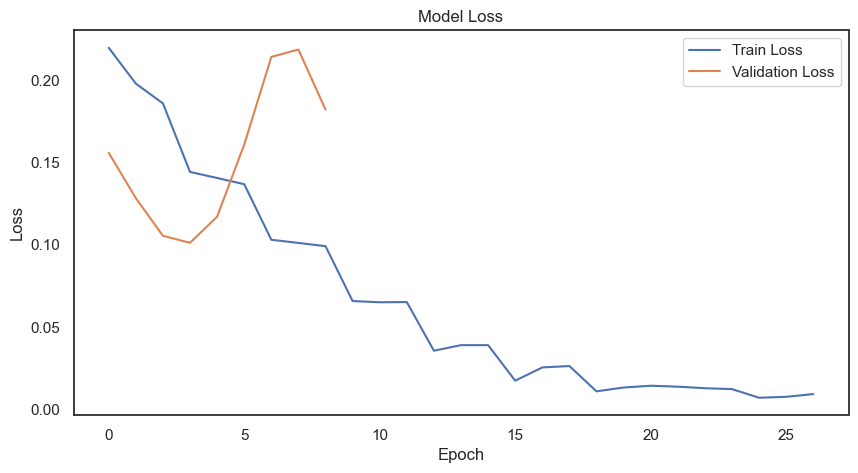

63/63 ━━━━━━━━━━━━━━━━━━━━ 33s 530ms/step
Class 0 AUC: 0.7335478472236058
Class 1 AUC: 0.9191932624113475
Class 2 AUC: 0.9411319612590799
Class 3 AUC: 0.9999746429730607
Class 4 AUC: 0.8142990110529378
Class 5 AUC: 0.9592480525333162
Class 6 AUC: 0.8709291760317537
Class 7 AUC: 1.0
Class 8 AUC: 0.778792267811721
Class 9 AUC: 0.7330420050001033
Class 10 AUC: 0.758562018557423
Class 11 AUC: 0.8233197588764724
Class 12 AUC: 1.0
Class 13 AUC: 0.9165260079878281
Class 14 AUC: 1.0
Class 15 AUC: 1.0
Class 16 AUC: 1.0
Class 17 AUC: 0.9447186147186148
Class 18 AUC: 0.9842188321935823
Class 19 AUC: 0.7148586505842444


/var/folders/b0/pcxb6s654pd13jyf_cx6mwp00000gn/T/ipykernel_23706/235224962.py:120: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(x='Class', y='AUC Score', data=auc_df, palette='viridis')


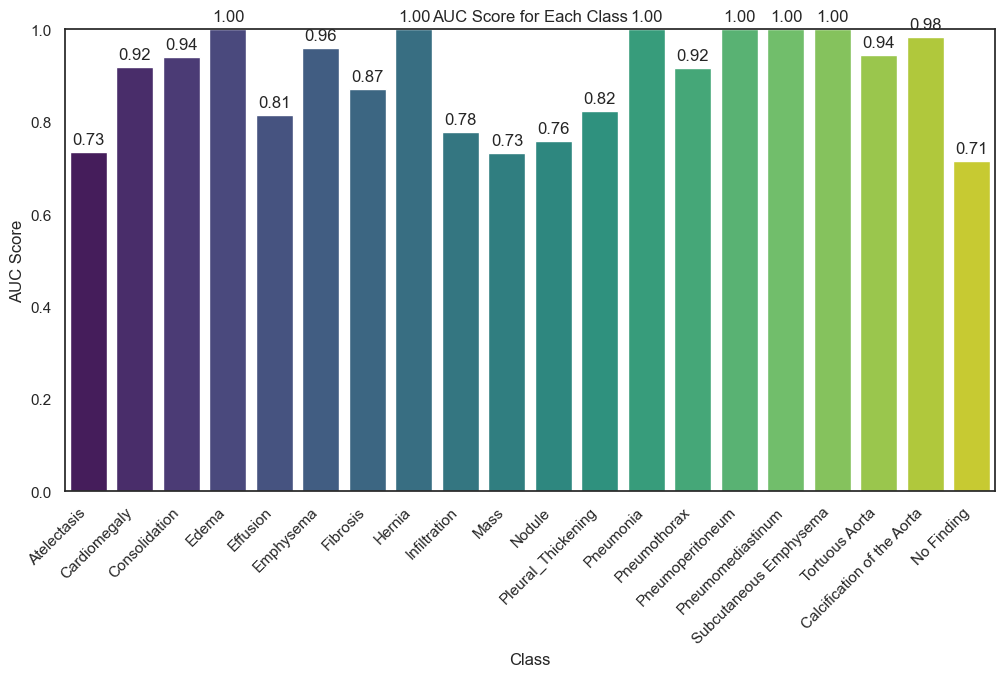

In [47]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, LeakyReLU, BatchNormalization, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score
import numpy as np
import pandas as pd

class LossHistory(Callback):
    def on_train_begin(self, logs=None):
        self.total_batches = 0
        self.losses = []
        self.val_losses = []
        self.iterations = []
        self.accuracy = []
        self.val_accuracy = []

    def on_batch_end(self, batch, logs=None):
        self.total_batches += 1
        if self.total_batches % 100 == 0:
            self.losses.append(logs.get('loss'))
            self.iterations.append(self.total_batches)

    def on_epoch_end(self, epoch, logs=None):
        self.val_losses.append(logs.get('val_loss'))
        self.accuracy.append(logs.get('accuracy'))
        self.val_accuracy.append(logs.get('val_accuracy'))

def create_yolo_model(input_shape, num_classes):
    model = Sequential()
    model.add(Input(shape=input_shape))

    model.add(Conv2D(32, (3, 3), padding='same'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(128, (3, 3), padding='same'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(256, (3, 3), padding='same'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(512, (3, 3), padding='same'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dense(num_classes, activation='sigmoid'))

    return model

# Assume the images are of shape (320, 320, 3) and there are 20 classes
input_shape = (320, 320, 3)
num_classes = y_train.shape[1]

# Create the model
model = create_yolo_model(input_shape, num_classes)

# Compile the model
learning_rate = 0.001
model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])

# Create the LossHistory callback
history = LossHistory()

# Create the EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
model.fit(x_train, y_train, validation_data=(x_valid, y_valid),
          epochs=30, batch_size=20, callbacks=[history, early_stopping])

# Plot the accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.accuracy, label='Train Accuracy')
plt.plot(history.val_accuracy, label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot the loss
plt.figure(figsize=(10, 5))
plt.plot(history.losses, label='Train Loss')
plt.plot(history.val_losses, label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate the model using AUC
y_pred = model.predict(x_test)

auc_scores = []
for i in range(y_test.shape[1]):
    auc = roc_auc_score(y_test[:, i], y_pred[:, i])
    auc_scores.append(auc)
    print(f"Class {i} AUC: {auc}")

# Plot the AUC scores
auc_df = pd.DataFrame({
    'Class': labels,
    'AUC Score': auc_scores
})

plt.figure(figsize=(12, 6))
bar_plot = sns.barplot(x='Class', y='AUC Score', data=auc_df, palette='viridis')

for p in bar_plot.patches:
    bar_plot.annotate(format(p.get_height(), '.2f'),
                      (p.get_x() + p.get_width() / 2., p.get_height()),
                      ha='center', va='center',
                      xytext=(0, 9),
                      textcoords='offset points')

plt.title('AUC Score for Each Class')
plt.xlabel('Class')
plt.ylabel('AUC Score')
plt.ylim(0, 1)
plt.xticks(rotation=45, ha='right')
plt.show()


In [48]:
# Evaluate the model on the training set
train_loss, train_accuracy = model.evaluate(x_train, y_train, verbose=0)
print(f'Training Accuracy: {train_accuracy:.4f}')

# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(x_valid, y_valid, verbose=0)
print(f'Validation Accuracy: {val_accuracy:.4f}')

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=0)
print(f'Test Accuracy: {test_accuracy:.4f}')


Training Accuracy: 0.8945
Validation Accuracy: 0.6430
Test Accuracy: 0.6310


The following code implements a convolutional neural network (CNN) for multi-class classification. The key differences compared to the previous model are as follows:

1. **Model Type**: This model is a convolutional neural network (CNN) designed for image classification, inspired by the YOLO (You Only Look Once) architecture but not a full YOLO implementation.

2. **Model Architecture**:
   - **Convolutional Layers**: 
     - The model includes multiple Conv2D layers with Leaky ReLU activations and MaxPooling2D layers to progressively downsample the input image.
     - This architecture is more complex and better suited for handling spatial data in images compared to the fully connected dense layers used in the previous model.
   - **Dense Layers**:
     - After flattening the output of the convolutional layers, the model includes a dense layer with 1024 neurons and Leaky ReLU activation before the final output layer.
     - The final layer uses a sigmoid activation function for multi-label classification, similar to the previous model.
   - **Input Shape**: The model takes images of shape (320, 320, 3) as input, leveraging the spatial dimensions of the image data, unlike the previous model which used flattened images.

3. **Optimization Methods**:
   - **Optimizer, Loss Function, and Evaluation Metric**: These remain the same as in the previous model (Adam with a learning rate of 0.001, binary_crossentropy, and accuracy, respectively).
   - **Early Stopping**: This model uses an EarlyStopping callback to prevent overfitting by monitoring the validation loss and stopping training if there is no improvement for 5 epochs, restoring the best weights.

4. **Training and Callbacks**:
   - The training process is similar, using the `LossHistory` callback to record losses and accuracies during training.
   - The batch size has been adjusted to 50 in this model compared to 20 in the previous model.

5. **Evaluation**:
   - The code also includes AUC evaluation, calculating and visualizing AUC scores for each class, similar to the previous model.

In summary, the primary difference lies in the use of convolutional layers for handling spatial features in images, which is a significant improvement for image data compared to the dense layers used in the previous model.


/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 398s 3s/step - accuracy: 0.1141 - loss: 0.2465 - val_accuracy: 0.3020 - val_loss: 0.1603
Epoch 2/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 390s 3s/step - accuracy: 0.3598 - loss: 0.1506 - val_accuracy: 0.4395 - val_loss: 0.1363
Epoch 3/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 419s 3s/step - accuracy: 0.5293 - loss: 0.1149 - val_accuracy: 0.5455 - val_loss: 0.1171
Epoch 4/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 418s 3s/step - accuracy: 0.6956 - loss: 0.0816 - val_accuracy: 0.6055 - val_loss: 0.1098
Epoch 5/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 411s 3s/step - accuracy: 0.8333 - loss: 0.0493 - val_accuracy: 0.6405 - val_loss: 0.1095
Epoch 6/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 391s 3s/step - accuracy: 0.9239 - loss: 0.0280 - val_accuracy: 0.6425 - val_loss: 0.1451
Epoch 7/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 398s 3s/step - accuracy: 0.9665 - loss: 0.0166 - val_accuracy: 0.6560 - val_loss: 0.1467
Epoch 8/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 406s 3s/step - accuracy: 0.9867 - loss: 0.0104 - val_accu

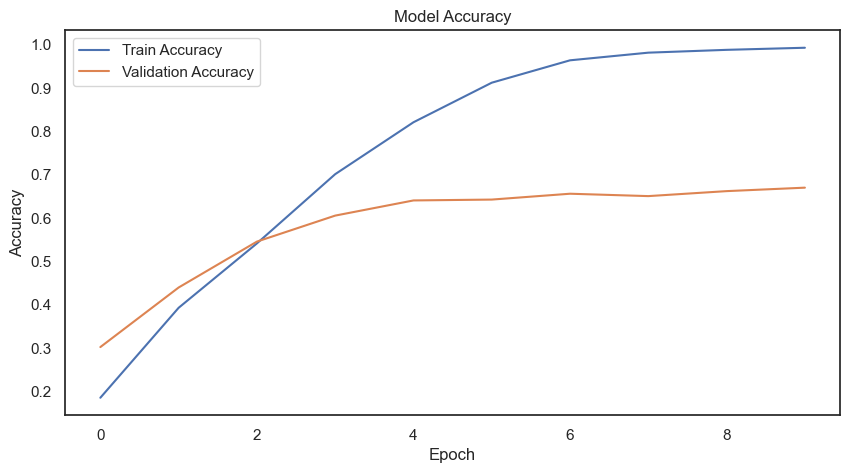

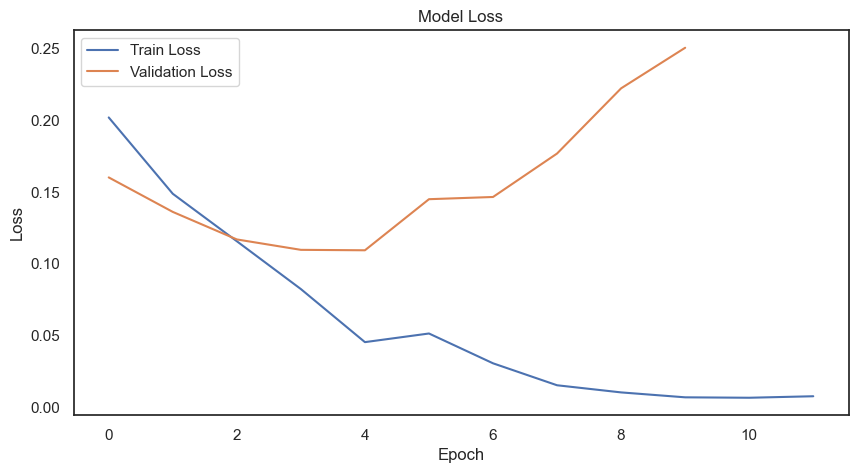

63/63 ━━━━━━━━━━━━━━━━━━━━ 33s 521ms/step
Class 0 AUC: 0.7328106632663225
Class 1 AUC: 0.9113874113475176
Class 2 AUC: 0.9240976846246972
Class 3 AUC: 1.0
Class 4 AUC: 0.7752356020942408
Class 5 AUC: 0.963153715744973
Class 6 AUC: 0.8552861598626984
Class 7 AUC: 1.0
Class 8 AUC: 0.7680599413483733
Class 9 AUC: 0.7206295584619516
Class 10 AUC: 0.7104287027310925
Class 11 AUC: 0.8151043174492888
Class 12 AUC: 1.0
Class 13 AUC: 0.9185051350323317
Class 14 AUC: 1.0
Class 15 AUC: 1.0
Class 16 AUC: 1.0
Class 17 AUC: 0.9241510341510342
Class 18 AUC: 0.9828691969670401
Class 19 AUC: 0.7454403819575324


/var/folders/b0/pcxb6s654pd13jyf_cx6mwp00000gn/T/ipykernel_23706/399529695.py:120: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(x='Class', y='AUC Score', data=auc_df, palette='viridis')


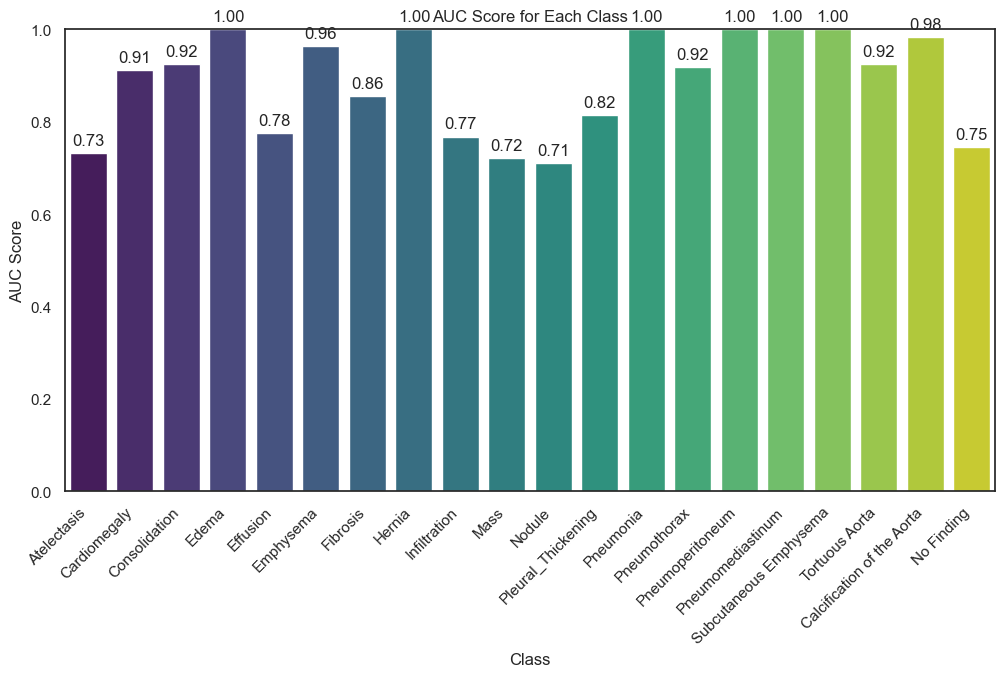

In [49]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, LeakyReLU, BatchNormalization, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score
import numpy as np
import pandas as pd

class LossHistory(Callback):
    def on_train_begin(self, logs=None):
        self.total_batches = 0
        self.losses = []
        self.val_losses = []
        self.iterations = []
        self.accuracy = []
        self.val_accuracy = []

    def on_batch_end(self, batch, logs=None):
        self.total_batches += 1
        if self.total_batches % 100 == 0:
            self.losses.append(logs.get('loss'))
            self.iterations.append(self.total_batches)

    def on_epoch_end(self, epoch, logs=None):
        self.val_losses.append(logs.get('val_loss'))
        self.accuracy.append(logs.get('accuracy'))
        self.val_accuracy.append(logs.get('val_accuracy'))

def create_yolo_model(input_shape, num_classes):
    model = Sequential()
    model.add(Input(shape=input_shape))

    model.add(Conv2D(32, (3, 3), padding='same'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(128, (3, 3), padding='same'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(256, (3, 3), padding='same'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(512, (3, 3), padding='same'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dense(num_classes, activation='sigmoid'))

    return model

# Assume the images are of shape (320, 320, 3) and there are 20 classes
input_shape = (320, 320, 3)
num_classes = y_train.shape[1]

# Create the model
model = create_yolo_model(input_shape, num_classes)

# Compile the model
learning_rate = 0.001
model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])

# Create the LossHistory callback
history = LossHistory()

# Create the EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
model.fit(x_train, y_train, validation_data=(x_valid, y_valid),
          epochs=30, batch_size=50, callbacks=[history, early_stopping])

# Plot the accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.accuracy, label='Train Accuracy')
plt.plot(history.val_accuracy, label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot the loss
plt.figure(figsize=(10, 5))
plt.plot(history.losses, label='Train Loss')
plt.plot(history.val_losses, label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate the model using AUC
y_pred = model.predict(x_test)

auc_scores = []
for i in range(y_test.shape[1]):
    auc = roc_auc_score(y_test[:, i], y_pred[:, i])
    auc_scores.append(auc)
    print(f"Class {i} AUC: {auc}")

# Plot the AUC scores
auc_df = pd.DataFrame({
    'Class': labels,
    'AUC Score': auc_scores
})

plt.figure(figsize=(12, 6))
bar_plot = sns.barplot(x='Class', y='AUC Score', data=auc_df, palette='viridis')

for p in bar_plot.patches:
    bar_plot.annotate(format(p.get_height(), '.2f'),
                      (p.get_x() + p.get_width() / 2., p.get_height()),
                      ha='center', va='center',
                      xytext=(0, 9),
                      textcoords='offset points')

plt.title('AUC Score for Each Class')
plt.xlabel('Class')
plt.ylabel('AUC Score')
plt.ylim(0, 1)
plt.xticks(rotation=45, ha='right')
plt.show()


In [50]:
# Evaluate the model on the training set
train_loss, train_accuracy = model.evaluate(x_train, y_train, verbose=0)
print(f'Training Accuracy: {train_accuracy:.4f}')

# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(x_valid, y_valid, verbose=0)
print(f'Validation Accuracy: {val_accuracy:.4f}')

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=0)
print(f'Test Accuracy: {test_accuracy:.4f}')


Training Accuracy: 0.9425
Validation Accuracy: 0.6405
Test Accuracy: 0.6365


Epoch 1/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 572s 3s/step - accuracy: 0.3445 - loss: 0.3741 - val_accuracy: 0.0515 - val_loss: 0.1953
Epoch 2/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 561s 3s/step - accuracy: 0.8027 - loss: 0.0777 - val_accuracy: 0.4795 - val_loss: 0.1529
Epoch 3/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 555s 3s/step - accuracy: 0.9832 - loss: 0.0266 - val_accuracy: 0.6585 - val_loss: 0.1116
Epoch 4/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 562s 3s/step - accuracy: 1.0000 - loss: 0.0087 - val_accuracy: 0.6670 - val_loss: 0.0938
Epoch 5/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 552s 3s/step - accuracy: 1.0000 - loss: 0.0036 - val_accuracy: 0.6765 - val_loss: 0.0894
Epoch 6/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 576s 3s/step - accuracy: 1.0000 - loss: 0.0022 - val_accuracy: 0.6745 - val_loss: 0.0929
Epoch 7/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 563s 3s/step - accuracy: 1.0000 - loss: 0.0016 - val_accuracy: 0.6750 - val_loss: 0.0968
Epoch 8/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 557s 3s/step - accuracy: 1.0000 - loss: 0.0012 - val_accu

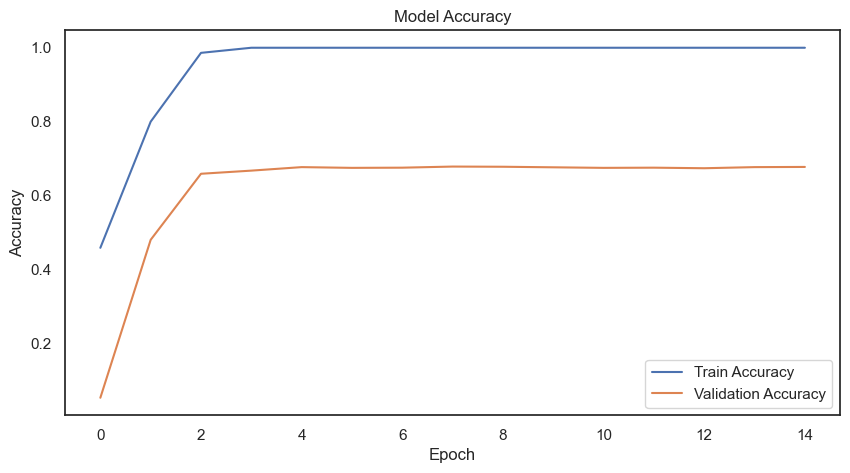

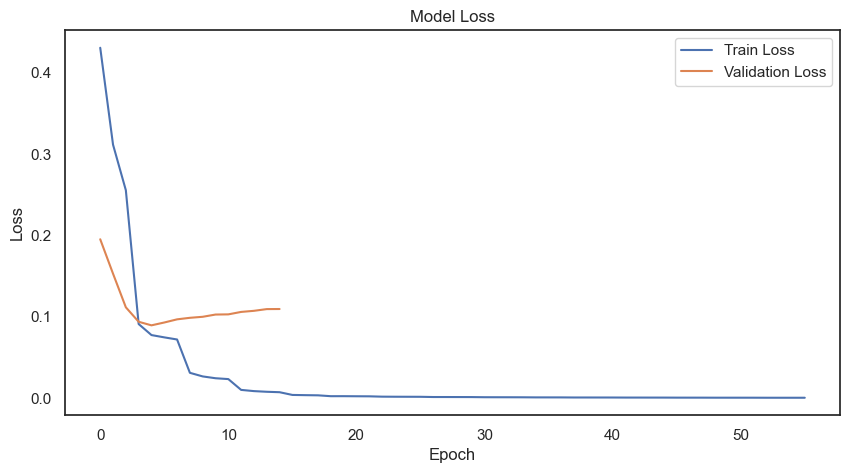

63/63 ━━━━━━━━━━━━━━━━━━━━ 35s 560ms/step
Class 0 AUC: 0.8089149449104422
Class 1 AUC: 0.9480762411347516
Class 2 AUC: 0.9646640435835351
Class 3 AUC: 1.0
Class 4 AUC: 0.8787201861547412
Class 5 AUC: 0.97333633768965
Class 6 AUC: 0.8685646576230479
Class 7 AUC: 1.0
Class 8 AUC: 0.779913097327922
Class 9 AUC: 0.7797733424244302
Class 10 AUC: 0.7341452205882354
Class 11 AUC: 0.8094557993811076
Class 12 AUC: 1.0
Class 13 AUC: 0.9387005515405097
Class 14 AUC: 1.0
Class 15 AUC: 1.0
Class 16 AUC: 1.0
Class 17 AUC: 0.9647907647907648
Class 18 AUC: 0.9834483711390603
Class 19 AUC: 0.740379444653851


/var/folders/b0/pcxb6s654pd13jyf_cx6mwp00000gn/T/ipykernel_41701/2708207840.py:127: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(x='Class', y='AUC Score', data=auc_df, palette='viridis')


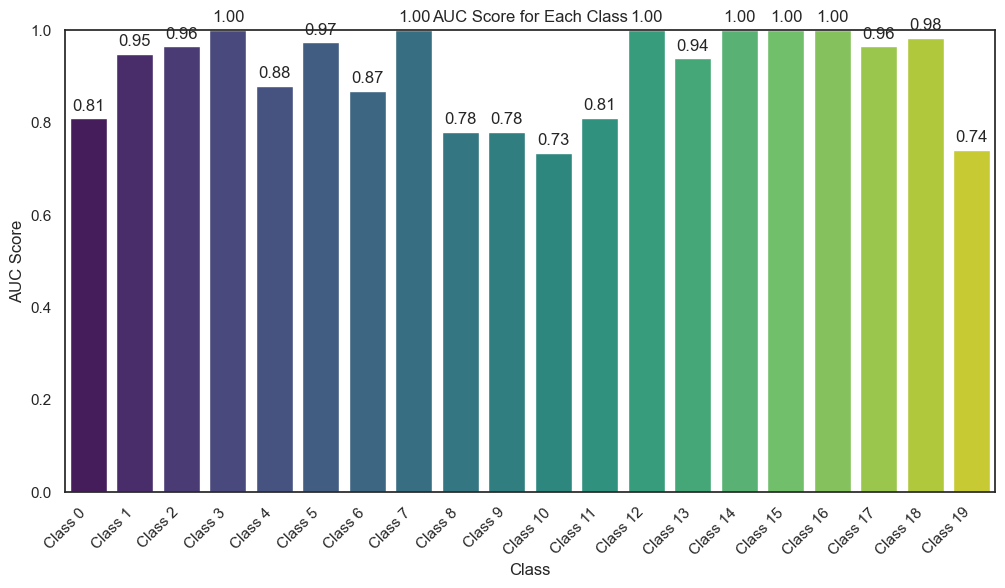

Training Accuracy: 1.0000
Validation Accuracy: 0.6765
Test Accuracy: 0.6755


In [33]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, LeakyReLU, BatchNormalization, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score
import numpy as np
import pandas as pd

class LossHistory(Callback):
    def on_train_begin(self, logs=None):
        self.total_batches = 0
        self.losses = []
        self.val_losses = []
        self.iterations = []
        self.accuracy = []
        self.val_accuracy = []

    def on_batch_end(self, batch, logs=None):
        self.total_batches += 1
        if self.total_batches % 50 == 0:  # Increased frequency of logging
            self.losses.append(logs.get('loss'))
            self.iterations.append(self.total_batches)

    def on_epoch_end(self, epoch, logs=None):
        self.val_losses.append(logs.get('val_loss'))
        self.accuracy.append(logs.get('accuracy'))
        self.val_accuracy.append(logs.get('val_accuracy'))

def create_yolo_model(input_shape, num_classes):
    model = Sequential()
    model.add(Input(shape=input_shape))

    model.add(Conv2D(32, (3, 3), padding='same'))
    model.add(BatchNormalization())  # Add Batch Normalization
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(BatchNormalization())  # Add Batch Normalization
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(128, (3, 3), padding='same'))
    model.add(BatchNormalization())  # Add Batch Normalization
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(256, (3, 3), padding='same'))
    model.add(BatchNormalization())  # Add Batch Normalization
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(512, (3, 3), padding='same'))
    model.add(BatchNormalization())  # Add Batch Normalization
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(1024))
    model.add(BatchNormalization())  # Add Batch Normalization
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dense(num_classes, activation='sigmoid'))

    return model

# Assume the images are of shape (320, 320, 3) and there are 20 classes
input_shape = (320, 320, 3)
num_classes = y_train.shape[1]

# Create the model
model = create_yolo_model(input_shape, num_classes)

# Compile the model
learning_rate = 0.0001  # Decreased learning rate
model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])

# Create the LossHistory callback
history = LossHistory()

# Create the EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)  # Increased patience

# Train the model
model.fit(x_train, y_train, validation_data=(x_valid, y_valid),
          epochs=50, batch_size=32, callbacks=[history, early_stopping])  # Increased epochs and decreased batch size

# Plot the accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.accuracy, label='Train Accuracy')
plt.plot(history.val_accuracy, label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot the loss
plt.figure(figsize=(10, 5))
plt.plot(history.losses, label='Train Loss')
plt.plot(history.val_losses, label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate the model using AUC
y_pred = model.predict(x_test)

auc_scores = []
for i in range(y_test.shape[1]):
    auc = roc_auc_score(y_test[:, i], y_pred[:, i])
    auc_scores.append(auc)
    print(f"Class {i} AUC: {auc}")

# Plot the AUC scores
labels = [f"Class {i}" for i in range(num_classes)]  # Ensure your class labels are correct
auc_df = pd.DataFrame({
    'Class': labels,
    'AUC Score': auc_scores
})

plt.figure(figsize=(12, 6))
bar_plot = sns.barplot(x='Class', y='AUC Score', data=auc_df, palette='viridis')

for p in bar_plot.patches:
    bar_plot.annotate(format(p.get_height(), '.2f'),
                      (p.get_x() + p.get_width() / 2., p.get_height()),
                      ha='center', va='center',
                      xytext=(0, 9),
                      textcoords='offset points')

plt.title('AUC Score for Each Class')
plt.xlabel('Class')
plt.ylabel('AUC Score')
plt.ylim(0, 1)
plt.xticks(rotation=45, ha='right')
plt.show()

# Evaluate the model on the training set
train_loss, train_accuracy = model.evaluate(x_train, y_train, verbose=0)
print(f'Training Accuracy: {train_accuracy:.4f}')

# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(x_valid, y_valid, verbose=0)
print(f'Validation Accuracy: {val_accuracy:.4f}')

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=0)
print(f'Test Accuracy: {test_accuracy:.4f}')


/var/folders/b0/pcxb6s654pd13jyf_cx6mwp00000gn/T/ipykernel_41701/1433788119.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(x='Class', y='AUC Score', data=auc_df, palette='viridis')


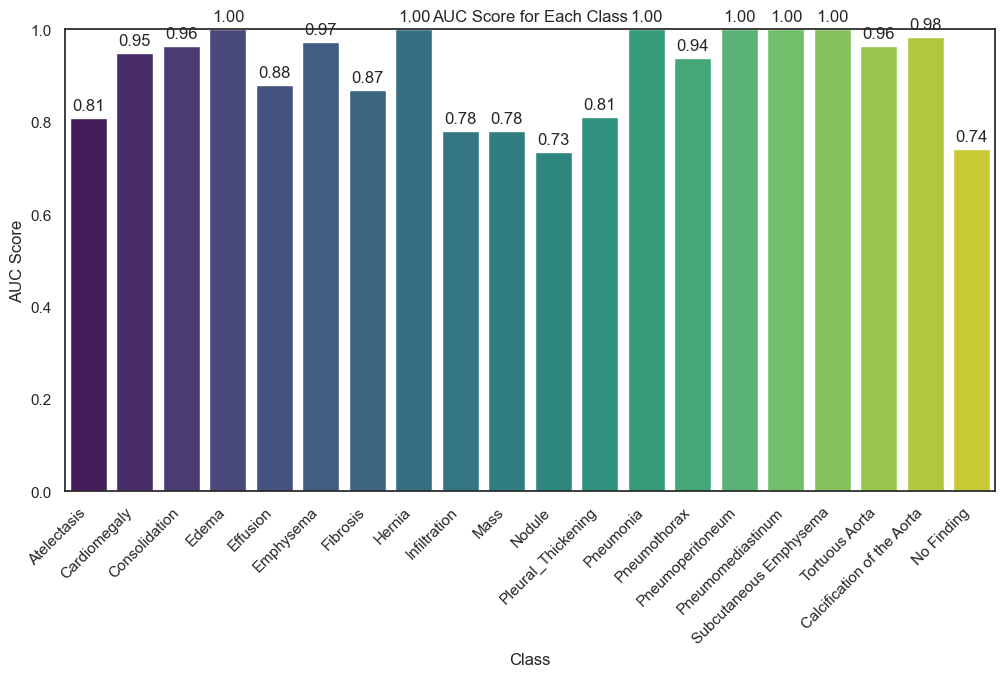

In [37]:
# Disease labels
disease_labels = [
    'Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion',
    'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule',
    'Pleural_Thickening', 'Pneumonia', 'Pneumothorax', 'Pneumoperitoneum',
    'Pneumomediastinum', 'Subcutaneous Emphysema', 'Tortuous Aorta', 'Calcification of the Aorta', 'No Finding'
]

# Plot the AUC scores
auc_df = pd.DataFrame({
    'Class': disease_labels,
    'AUC Score': auc_scores
})

plt.figure(figsize=(12, 6))
bar_plot = sns.barplot(x='Class', y='AUC Score', data=auc_df, palette='viridis')

for p in bar_plot.patches:
    bar_plot.annotate(format(p.get_height(), '.2f'),
                      (p.get_x() + p.get_width() / 2., p.get_height()),
                      ha='center', va='center',
                      xytext=(0, 9),
                      textcoords='offset points')

plt.title('AUC Score for Each Class')
plt.xlabel('Class')
plt.ylabel('AUC Score')
plt.ylim(0, 1)
plt.xticks(rotation=45, ha='right')
plt.show()